In [228]:
import vnstock as vns
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from MFI import add_mfi
from RSI import add_rsi
from MACD import add_macd 
from cosine import cosine
from bollinger_bands import add_bollinger_bands

from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

In [229]:
ticker = 'STB'

In [230]:
df = vns.stock_historical_data(symbol = ticker, start_date="2014-07-01", 
                            end_date='2024-07-01', resolution='1D', type='stock')


In [231]:
df_temp = df.copy()

In [232]:
len(df_temp)

2499

In [233]:
# df = df[round(len(df)*3/4):]

In [234]:
def calculate_indicators(data):
    add_mfi(data)
    
    data = data[['time', 'close', 'MFI']]

    # data.set_index('time', inplace = True)

    data = data.dropna()
    
    add_bollinger_bands(data)

    add_rsi(data)

    add_macd(data)
    
    data.dropna(inplace = True)
    
    # data.reset_index(inplace = True, drop = True)

    data['sma10'] = data['close'].rolling(window = 10, min_periods = 1).mean()
    
    data['sma20'] = data['close'].rolling(window = 20, min_periods = 1).mean()

    data['sma50'] = data['close'].rolling(window = 50, min_periods = 1).mean()

    data['sma200'] = data['close'].rolling(window = 200, min_periods = 1).mean()
    
    data['sma5'] = data['close'].rolling(window = 5, min_periods = 1).mean()

    data['ema'] = data['close'].ewm(span = 10).mean()

    # data.dropna(inplace = True)
    
    data.reset_index(inplace = True, drop = True)

    return data

In [235]:
df = calculate_indicators(df)
df

,time,close,MFI,SMA,SD,UB,LB,RSI,EMA12,EMA26,MACD,Signal_Line,sma10,sma20,sma50,sma200,sma5,ema
0,2014-07-28,16590,39.307531,16822.40,112.972470,17048.344940,16596.455060,36.363636,16763.888558,16835.351585,-71.463027,-54.501529,16590.0,16590.0,16590.0,16590.00,16590.0,16590.000000
1,2014-07-29,16507,37.742998,16797.50,124.863504,17047.227009,16547.772991,33.333333,16724.367241,16811.029246,-86.662004,-60.933624,16548.5,16548.5,16548.5,16548.50,16548.5,16544.350000
2,2014-07-30,16259,39.979928,16768.50,172.850255,17114.200509,16422.799491,26.688103,16652.772281,16770.138190,-117.365909,-72.220081,16452.0,16452.0,16452.0,16452.00,16452.0,16429.641196
3,2014-07-31,16342,41.152220,16739.50,193.198425,17125.896851,16353.103149,33.360129,16604.961161,16738.424250,-133.463089,-84.468683,16424.5,16424.5,16424.5,16424.50,16424.5,16400.767327
4,2014-08-01,16259,36.617410,16706.35,215.795048,17137.940095,16274.759905,21.447028,16551.736367,16702.911343,-151.174976,-97.809941,16391.4,16391.4,16391.4,16391.40,16391.4,16360.069783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475,2024-06-25,29600,56.951641,30150.00,1109.528112,32369.056224,27930.943776,27.142857,30265.848953,29905.358742,360.490211,525.876690,30600.0,30150.0,28871.0,29662.00,30280.0,30276.458729
2476,2024-06-26,29500,46.629016,30212.50,1029.163559,32270.827118,28154.172882,23.188406,30148.026037,29875.332169,272.693869,475.240126,30415.0,30212.5,28884.0,29644.25,30000.0,30135.284415
2477,2024-06-27,29200,41.715281,30280.00,902.540275,32085.080549,28474.919451,14.492754,30002.175878,29825.307563,176.868314,415.565764,30170.0,30280.0,28886.0,29625.25,29690.0,29965.232703
2478,2024-06-28,28800,35.254973,30327.50,785.305003,31898.110006,28756.889994,18.181818,29817.225743,29749.358855,67.866887,346.025988,29995.0,30327.5,28912.0,29606.75,29320.0,29753.372212


In [236]:
def add_trend(data, fast, slow):
    data['trend'] = 'None'
    data.loc[data.iloc[np.where((data[fast] > data[slow]) & \
                                (data[fast].shift(1) < data[slow].shift(1)))].index, 'trend'] = 'Up'
    # Ở ngày trước đó sma50 đang thấp hơn, hôm nay cao hơn
    data.loc[data.iloc[np.where((data[fast] < data[slow]) & \
                                (data[fast].shift(1) > data[slow].shift(1)))].index, 'trend'] = 'Down'
    # Ở ngày trước đó sma50 đang cao hơn, hôm nay thấp hơn

    return data

In [237]:
slow = 'sma50'
fast = 'sma20'
df = add_trend(df, fast, slow)
df.reset_index(inplace= True, drop = True)

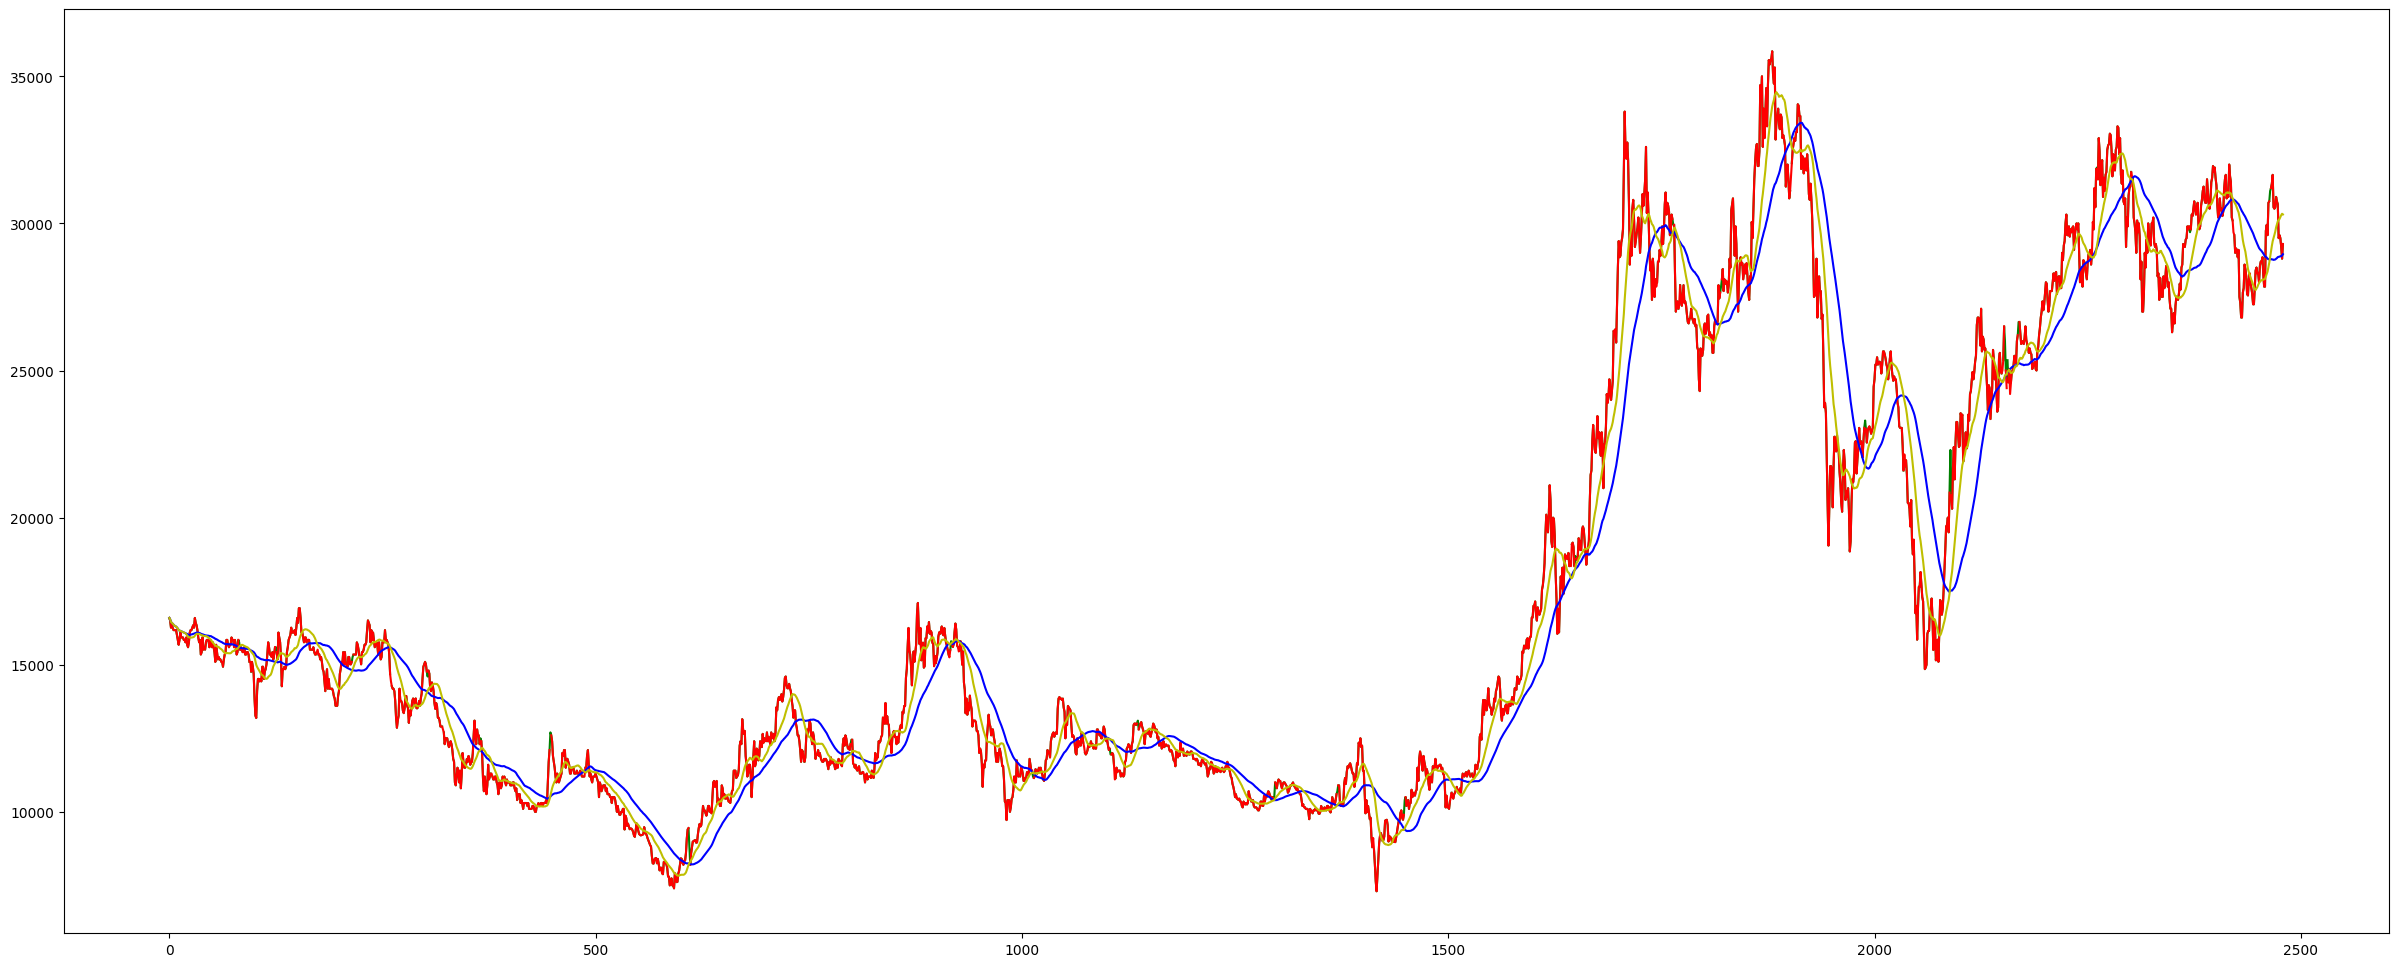

In [238]:
start = 0
plt.subplots(figsize =(30,12))

up_df = df.copy()
up_df[up_df['trend'] == 'Down'] = np.nan

down_df = df.copy()
down_df[down_df['trend'] == 'Up'] = np.nan

plt.plot(up_df['close'], label = "Uptrend", color = "g")
plt.plot(down_df['close'], label = "Downtrend", color = "r")
plt.plot(df[slow], color = 'b')
plt.plot(df[fast], color = 'y')


In [239]:
df_len = len(df)
train_length = 0.85 
start_global = round(df_len * train_length)
df_train = df[:start_global]
df_test = df[start_global:]

In [240]:
df.iloc[start_global]

time             2022-12-29
close                 22350
MFI               55.297853
SMA                 22392.5
SD               874.383241
UB             24141.266483
LB             20643.733517
RSI               45.454545
EMA12           22475.52693
EMA26          21566.477115
MACD             909.049816
Signal_Line      1115.87171
sma10               22725.0
sma20               22392.5
sma50              19138.94
sma200             22667.48
sma5                22390.0
ema            22551.477712
trend                  None
Name: 2108, dtype: object

In [241]:
def RSI_signal(data, index):
    if data['RSI'].iloc[index] <= 70 and data['RSI'].iloc[index - 1] >= 70:
        return -1
    elif data['RSI'].iloc[index] >= 30 and data['RSI'].iloc[index - 1] <= 30:
        return 1
    else:
        return 0
    
def MFI_signal(data, index):
    if data['MFI'].iloc[index] <= 80 and data['MFI'].iloc[index - 1] >= 80:
        return -1
    elif data['MFI'].iloc[index] >= 20 and data['MFI'].iloc[index - 1] <= 20:
        return 1
    else:
        return 0
    
def MACD_signal(data, index):
    if data['MACD'].iloc[index] >= data['Signal_Line'].iloc[index] and \
        data['MACD'].iloc[index - 1] <= data['Signal_Line'].iloc[index - 1]:
        return -1
    elif data['MACD'].iloc[index] <= data['Signal_Line'].iloc[index] and \
        data['MACD'].iloc[index - 1] >= data['Signal_Line'].iloc[index - 1]:
        return 1    
    else:
        return 0
    
def bollinger_bands_signal(data, index):
    if data['close'].iloc[index] <= data['LB'].iloc[index]\
        and data['close'].iloc[index - 1] >= data['LB'].iloc[index - 1]:
        return 1
    elif data['close'].iloc[index] >= data['UB'].iloc[index] and \
        data['close'].iloc[index - 1] <= data['UB'].iloc[index - 1]:
        return -1
    else:
        return 0
    
# def pattern_matching(start, window, indicator):
#     df_temp = df_test[indicator].iloc[start-window + 1:start + 1]
#     df_window = df_train[indicator].copy()  
#     df_window -= df_window.iloc[0]
#     cosines = []
#     for i in range(len(df_window)-window):
#         df_compare = df_window.iloc[i:i+window].copy()
#         df_compare -= df_compare.iloc[0]
#         cosines.append(cosine(df_temp, df_compare, window))
#     return cosines.index(max(cosines))

# def matching_signal(data, start):
#     pattern_start = pattern_matching(start, window, indicator)
#     predicted_earnings = data[indicator].iloc[pattern_start + window*2 - 1] - data[indicator].iloc[pattern_start + window - 1]
    
#     if predicted_earnings > 0:
#         return 0.25
#     else:
#         return -0.25

def pattern_matching(start, window, indicator):
    df_temp = df_test[indicator].iloc[start-window : start + 1] #start >= window
    df_window = df_train[indicator].copy()  
    cosines = []
    for i in range(len(df_window)-window):
        df_compare = df_window.iloc[i:i+window].copy()
        cosines.append(cosine(df_temp, df_compare, window))
    return cosines.index(max(cosines))

def matching_signal(data, start):
    pattern_start = pattern_matching(start, window, indicator)
    predicted_earnings = data[indicator].iloc[pattern_start + window*2 - 1] - data[indicator].iloc[pattern_start + window - 1]
    
    if predicted_earnings > 0:
        return 0.25
    else:
        return -0.25    

def calculate_signal(data, index, signal_list):
    temp = 0
    for signal in signal_list:
        temp += signal_dict[signal](data, index)
    return temp

def advance_day(day, money, debt):
   day += 1
   if day == 20:
      day = 0
      money += 1000000
      debt += 1000000
   return day, money, debt

In [242]:
signal_dict = {'MFI': MFI_signal, 'MACD': MACD_signal, 'bollinger_bands': bollinger_bands_signal, 'RSI': RSI_signal, 'matching': matching_signal}

signal_list = ['bollinger_bands']

In [243]:
def match_pattern(data, start_date, window): #Put in df['close']
    target_period = ((data.iloc[start_date : start_date+window] - data.iloc[start_date]).dropna()).values
    search_period = data.iloc[:start_date]
    lowest_distance = np.inf
    lowest_index = 0
    for i in range(len(search_period) - window):
        temp_period = ((search_period.iloc[i : i+window] - search_period.iloc[i]).dropna()).values
        temp_distance = np.linalg.norm(temp_period - target_period, ord = 2)
        if temp_distance < lowest_distance:
            print(f"i: {i}, distance: {temp_distance}")
            lowest_index = i
            lowest_distance = temp_distance
    return lowest_index

### Pattern Matching

In [244]:
window = 100
best_match = match_pattern(df['close'], start_global, window)
best_match

i: 0, distance: 43131.513409570965
i: 1, distance: 42669.29010424242
i: 2, distance: 40812.230801562415
i: 5, distance: 40797.06073971506
i: 9, distance: 39913.435169125696
i: 10, distance: 38396.06323570165
i: 11, distance: 36893.52042025808
i: 22, distance: 36410.894784391116
i: 37, distance: 35198.62431970886
i: 53, distance: 34277.170449148805
i: 54, distance: 30851.482606189285
i: 61, distance: 30411.442714872966
i: 63, distance: 28970.291075513895
i: 100, distance: 24088.720202617656
i: 101, distance: 19894.032924472605
i: 102, distance: 19217.650480742956
i: 578, distance: 18412.732008042694
i: 579, distance: 18111.598493782927
i: 585, distance: 16713.20136897776
i: 586, distance: 16393.889105395338
i: 587, distance: 14466.11903725391
i: 591, distance: 14289.793560440263
i: 592, distance: 13618.458062497384
i: 595, distance: 13171.68933736292
i: 596, distance: 13049.915708540037
i: 611, distance: 11093.380909353109


611

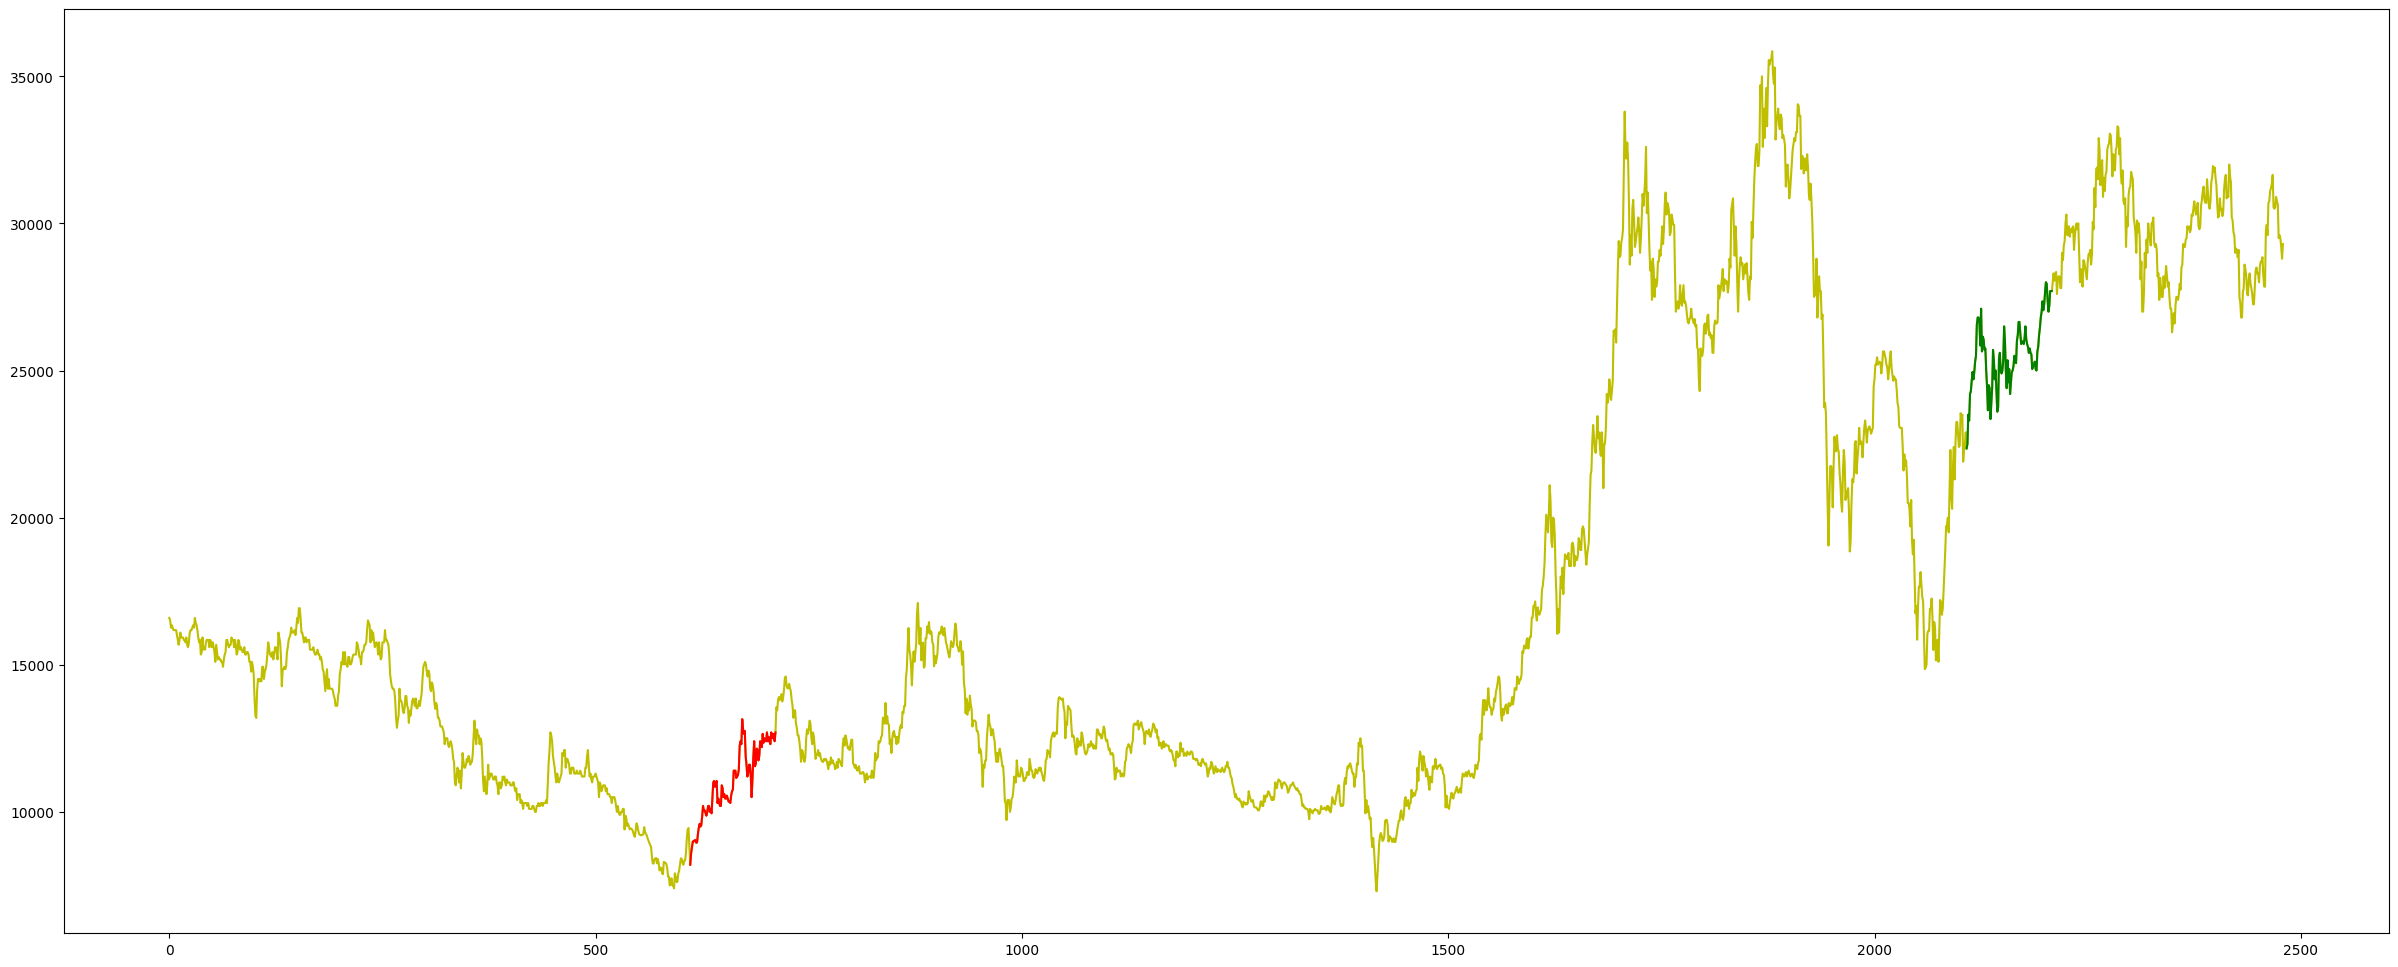

In [245]:
plt.subplots(figsize = (30,12))

plt.plot(df['close'], color = 'y')
plt.plot(df.loc[best_match:best_match + window, 'close'], color = 'r')
plt.plot(df.loc[start_global:start_global + window, 'close'], color = 'g')

In [ ]:
# For testing parameters
def train_parameters(data):
    profit_and_loss = []

    for i in range(1,41):
        for j in range(0,i):
            indicator = 'close'
            start = 0  # Is the current day, must be equal to or higher than window
            df_matching = df_train.copy()
            budget = 10000000  # How much money to start with, doesnt really matter
            total_assets = [10000000]
            stocks_holding = 0
            buy_points = []
            sell_points = []
            signal = 0

            upper_signal = i/10
            lower_signal = -i/10
            decay = j/10
            
            day = 0
            added = 0

            for k in range(len(df_matching) - start):
                current_price = df_matching['close'].iloc[start]
                signal = signal + calculate_signal(df_matching, start, signal_list)
                if signal >= upper_signal:
                    stocks_to_buy = (budget * 3/4) // current_price  #Spends half the budget to buy
                    
                    if stocks_to_buy > 0:
                        budget -= stocks_to_buy * current_price
                        stocks_holding += stocks_to_buy
                        buy_points.append(start)
                        # signal = signal // 2
                        
                elif signal <= lower_signal:
                    if stocks_holding > 0:
                        sell_points.append(start)
                        stocks_sold = stocks_holding
                        budget += stocks_sold * current_price
                        stocks_holding -= stocks_sold 
                        # signal = signal // 2
                    # sell_points.append(start)  # Append selling point regardless
                total_assets.append(budget + stocks_holding*current_price)
                start += 1
                
                if signal >= 0:
                    signal = max(0, signal - decay)
                else:
                    signal = min(0, signal + decay)
                # Decaying the signal
                day, budget, added = advance_day(day, budget, added)

            current_price = df_matching['close'].iloc[-1]
            total_assets.append(budget + stocks_holding * current_price)

            profit_and_loss.append([((total_assets[-1] - total_assets[0]- added)/total_assets[0]) * 100, i/10, j/10])